<a href="https://colab.research.google.com/github/jean-johnson-zwix/cnn_cifar_classification/blob/main/OpenCVBootcamp_CIFARClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementing a CNN in TensorFlow and Keras**

* Implement a Convolutional Neural Network (CNN) from scratch using Keras
* CNN architecture similar to the structure of VGG-16 but with fewer layers
* Train on a small dataset called CIFAR-10.
*  New layer type called Dropout, which is often used in models to mitigate the effects of overfitting.

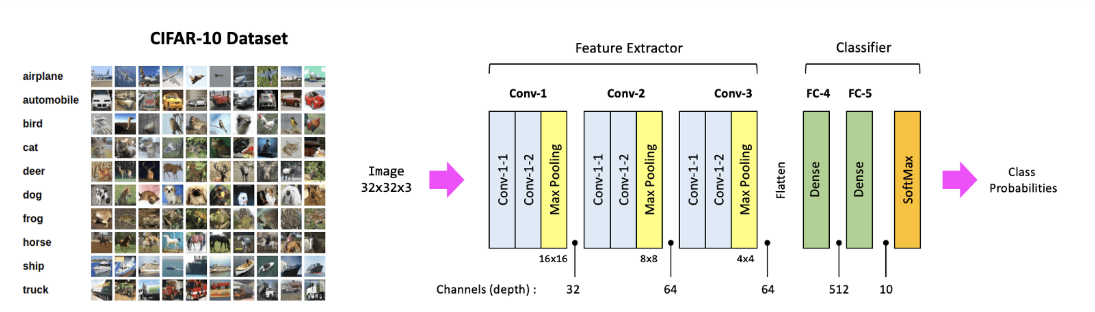

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

**LOAD CIFAR-10 DATASET**

The CIFAR-10 dataset is included in TensorFlow, so we can load the dataset using the load_data() function as shown in the code cell below and confirm the number of samples and the shape of the data.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


**Display Sample Images from the Dataset**

It's always a good idea to inspect some images in a dataset, as shown below. Remember, the images in CIFAR-10 are quite small, only 32x32 pixels, so while they don’t have a lot of detail, there's still enough information in these images to support an image classification task.

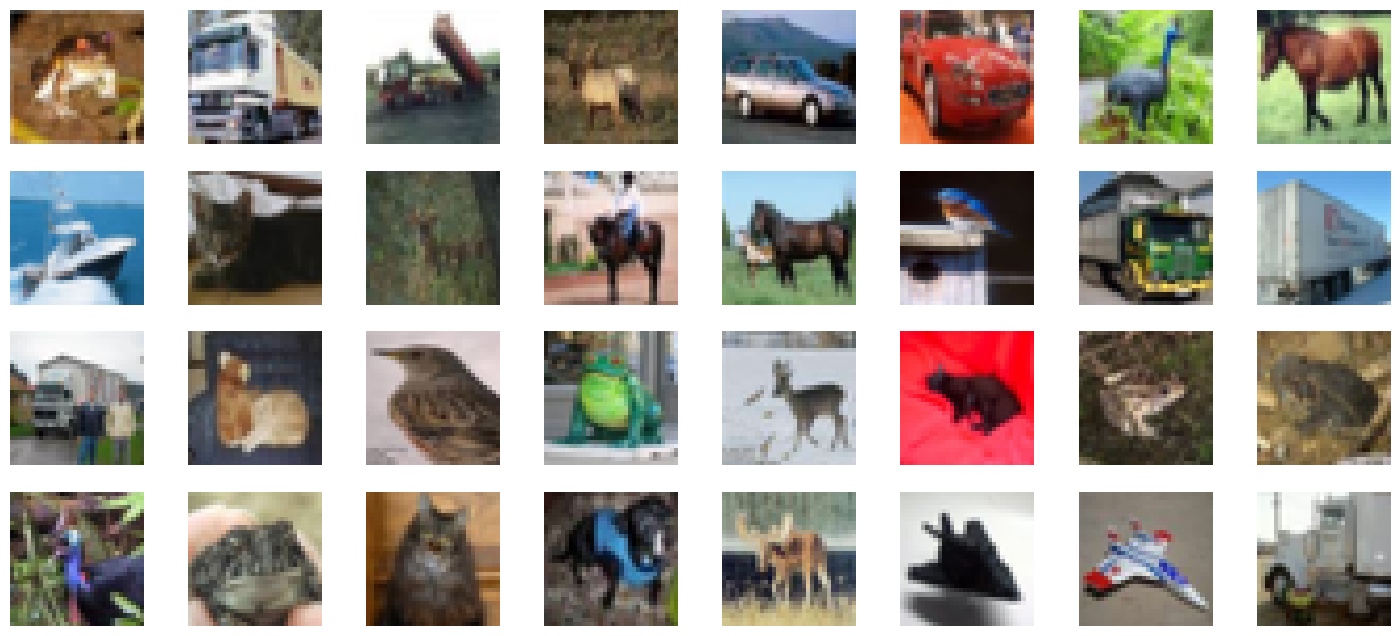

In [4]:
plt.figure(figsize=(18, 8))

num_rows = 4
num_cols = 8

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows * num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i, :, :])
    plt.axis("off")

**Dataset Preprocessing**

Here, we normalize the image data to the range [0,1]. This is very common when working with image data which helps the model train more efficiently. We also convert the integer labels to one-hot encoded labels

In [5]:
# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32")  / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

Original (integer) label for the first training sample:  [6]
After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


**Dataset and Training Configuration Parameters**

Before we describe the model implementation and training, we’re going to apply a little more structure to our training process by using the dataclasses module in python to create simple DatasetConfig and TrainingConfig classes to organize several data and training configuration parameters. This allows us to create data structures for configuration parameters, as shown below. The benefit of doing this is that we have a single place to go to make any desired changes.

In [10]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

**CNN Model Implementation in Keras**

In this section, we will define a simple CNN model in Keras and train it on the CIRFAR-10 dataset. Recall from a previous notebook the following steps required to define and train a model in Keras.

1. Build/Define a network model using predefined layers in Keras
2. Compile the model with model.compile()
3. Train the model with model.fit()

**Model Structure**

The model contains three convolutional blocks followed by a fully connected layer and an output layer.

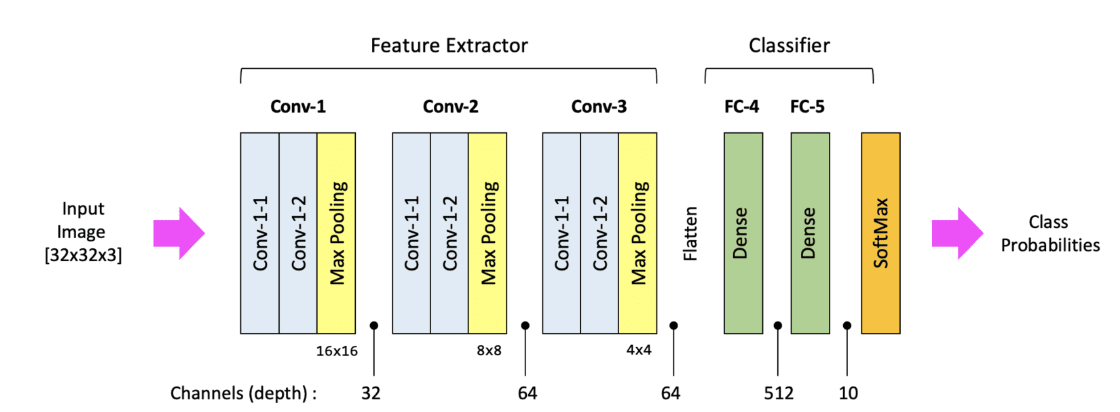

We first start by instantiating the model by calling the sequential() method. This allows us to build a model sequentially by adding one layer at a time. Noticed that we define three convolutional blocks and that their structure is very similar.

**Define the Convolutional Blocks**

Let’s start with the very first convolutional layer in the first convolutional block. To define a convolutional layer in Keras, we call the Conv2D() function, which takes several input arguments. First, we defined the layer to have 32 filters. The kernel size for each filter is 3 (which is interpreted as 3x3). We use a padding option called same, which will pad the input tensor so that the output of the convolution operation has the same spatial size as the input. This is not required, but it’s commonly used. if you don’t explicitly specify this padding option, then the default behavior has no padding, and therefore, the spatial size of output from the convolutional layer will be slightly smaller than the input size. We use a ReLU activation function in all the layers in the Network except for the output layer.

For the very first convolutional layer, we need to specify the shape of the input, but for all subsequent layers, this is not necessary since the shape of the input is automatically computed based on the shape of the output from previous layers, so we have two convolutional layers with 32 filters each, and then we follow that with a max pooling layer that has a window size of (2x2), so the output shape from this first convolution block is (16x16 x32). Next, we have the second convolutional block, which is nearly identical to the first, with the exception that we have 64 filters in each convolutional layer instead of 32, and then finally, the third convolutional block is an exact copy of the second convolutional block.



Note: The number of filters in each convolutional layer is something that you will need to experiment with. A larger number of filters allows the model to have a greater learning capacity, but this also needs to be balanced with the amount of data available to train the model. Adding too many filters (or layers) can lead to overfitting, one of the most common issues encountered when training models.

In [6]:
def cnn_model(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

**Define the Classifier**

Before we define the fully connected layers for the classifier, we need to first flatten the two-dimensional activation maps that are produced by the last convolutional layer (which have a spatial shape of 4x4 with 64 channels). This is accomplished by calling the flatten() function to create a 1-dimensional vector of length 1024. We then add a densely connected layer with 512 neurons and a fully connected output layer with ten neurons because we have ten classes in our dataset. And to avoid any confusion, we’ve also provided a detailed diagram of the fully connected layers.

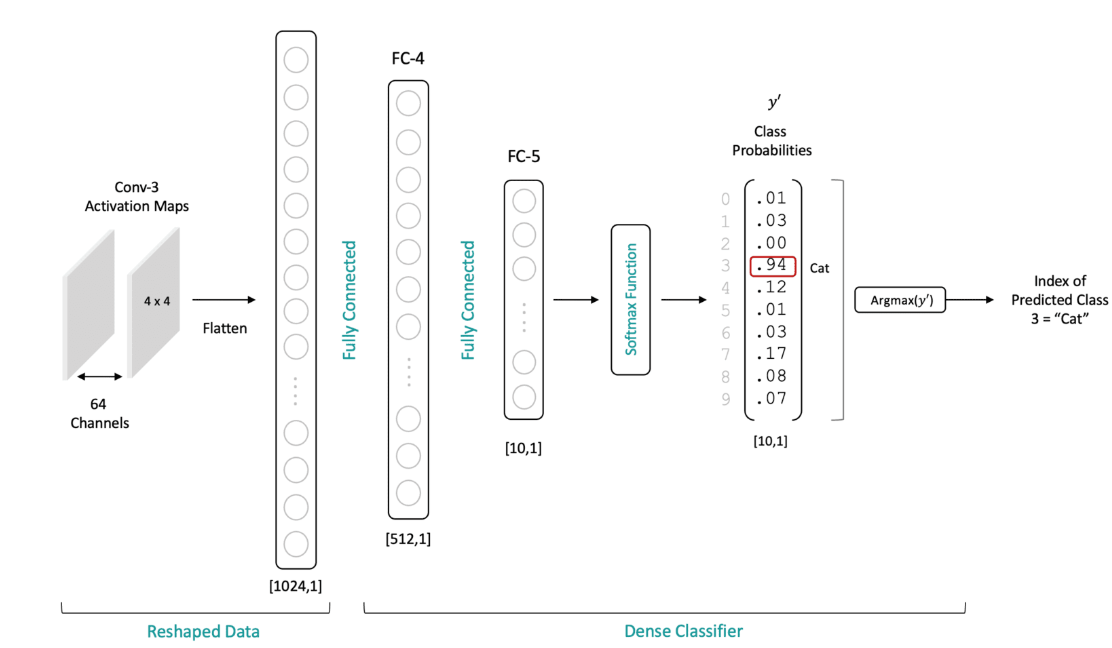

**Create the Model**

We can now create an instance of the model by calling the function above and use the summary() method to display the model summary to the console.

In [7]:
# Create the model.
model = cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,354 (2.55 MB)

 Trainable params: 669,354 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the Model**

The next step is to compile the model, where we specify the optimizer type and loss function and any additional metrics we would like recorded during training. Here we specify RMSProp as the optimizer type for gradient descent, and we use a cross-entropy loss function which is the standard loss function for classification problems. We specifically use categorical_crossentropy since our labels are one-hot encoded. Finally, we specify accuracy as an additional metric to record during training. The value of the loss function is always recorded by default, but if you want accuracy, you need to specify it.

In [8]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

**Train the Model**

Since the dataset does not include a validation dataset, and since we did not previously split the training dataset to create a validation dataset, we will use the validation_split argument below so that 30% of the training dataset is automatically reserved for validation. This approach reserves the last 30% of the dataset for training. This is a very convenient approach, but if the training dataset has any specific ordering (say, ordered by classes), you will need to take steps to randomize the order before splitting.

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_split=.3,
                   )

Epoch 1/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.1696 - loss: 2.2346 - val_accuracy: 0.2161 - val_loss: 2.0779
Epoch 2/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.3416 - loss: 1.7976 - val_accuracy: 0.2986 - val_loss: 2.0198
Epoch 3/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.4395 - loss: 1.5595 - val_accuracy: 0.4331 - val_loss: 1.5672
Epoch 4/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5010 - loss: 1.3784 - val_accuracy: 0.4971 - val_loss: 1.4416
Epoch 5/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.5594 - loss: 1.2278 - val_accuracy: 0.4743 - val_loss: 1.5187
Epoch 6/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.6114 - loss: 1.1058 - val_accuracy: 0.6085 - val_loss: 1.1072
Epoch 7/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6556 - loss: 0.9722 - val_accuracy: 0.6367 - val_loss: 1.0380
Epoch 8/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6904 - loss: 0.8669 - val_accu

**Plot the Training Results**

The function below is a convenience function to plot training and validation losses and training and validation accuracies. It has a single required argument which is a list of metrics to plot.

In [12]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

The loss and accuracy metrics can be accessed from the history object returned from the fit method. We access the metrics using predefined dictionary keys, as shown below.

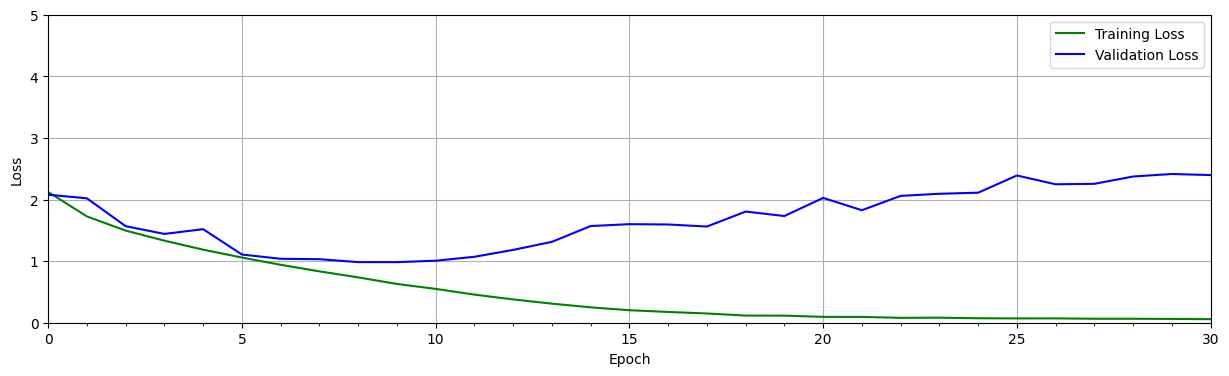

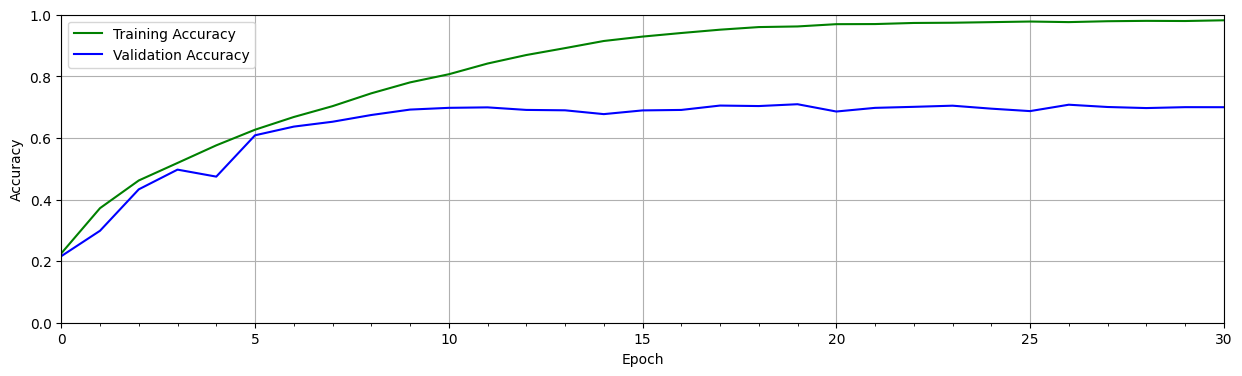

In [13]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

The results from our baseline model reveal that the model is overfitting. Notice that the validation loss increases after about ten epochs of training while the training loss continues to decline. This means that the network learns how to model the training data well but does not generalize to unseen test data well. The accuracy plot shows a similar trend where the validation accuracy levels off after about ten epochs while the training accuracy continues to approach 100% as training progresses. This is a common problem when training neural networks and can occur for a number of reasons. One reason is that the model can fit the nuances of the training dataset, especially when the training dataset is small.

**Adding Dropout to the Model**

To help mitigate this problem, we can employ one or more regularization strategies to help the model generalize better. Regularization techniques help to restrict the model's flexibility so that it doesn't overfit the training data. One approach is called Dropout, which is built into Keras. Dropout is implemented in Keras as a special layer type that randomly drops a percentage of neurons during the training process. When dropout is used in convolutional layers, it is usually used after the max pooling layer and has the effect of eliminating a percentage of neurons in the feature maps. When used after a fully connected layer, a percentage of neurons in the fully connected layer are dropped.

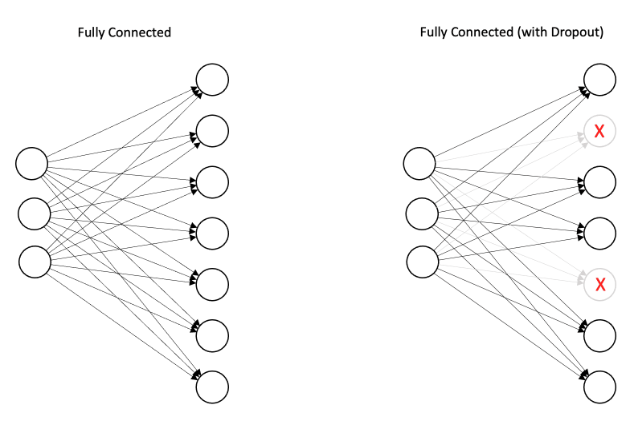

In the diagram below, we add a dropout layer at the end of each convolutional block and also after the dense layer in the classifier. The input argument to the Dropout function is the fraction of neurons to (randomly) drop from the previous layer during the training process.

**Define the Model (with Dropout)**

In [14]:
def cnn_model_dropout(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

**Create the Model (with Dropout)**

In [15]:
# Create the model.
model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,354 (2.55 MB)

 Trainable params: 669,354 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

**Compile & Train the Model (with Dropout)**

In [16]:
model_dropout.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_dropout.fit(X_train,
                            y_train,
                            batch_size=TrainingConfig.BATCH_SIZE,
                            epochs=TrainingConfig.EPOCHS,
                            verbose=1,
                            validation_split=.3,
                           )

Epoch 1/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.1469 - loss: 2.2487 - val_accuracy: 0.3174 - val_loss: 1.9087
Epoch 2/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.3169 - loss: 1.8688 - val_accuracy: 0.3505 - val_loss: 1.7952
Epoch 3/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.3855 - loss: 1.6750 - val_accuracy: 0.4599 - val_loss: 1.4588
Epoch 4/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.4534 - loss: 1.5120 - val_accuracy: 0.4775 - val_loss: 1.4735
Epoch 5/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.4972 - loss: 1.3898 - val_accuracy: 0.5061 - val_loss: 1.4177
Epoch 6/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.5423 - loss: 1.2878 - val_accuracy: 0.5743 - val_loss: 1.1823
Epoch 7/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.5779 - loss: 1.1935 - val_accuracy: 0.5766 - val_loss: 1.1727
Epoch 8/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.6030 - loss: 1.1158 - val_accu

**Plot the training results**

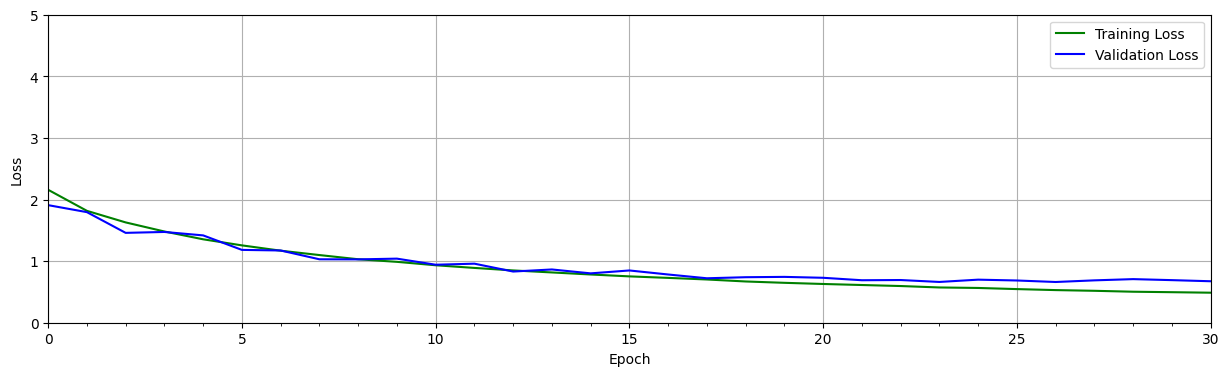

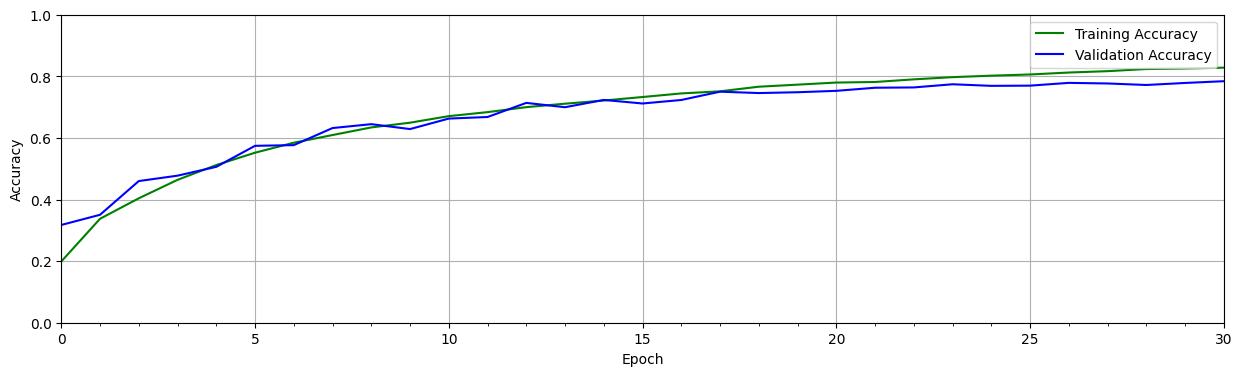

In [17]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

In the plots above, the training curves align very closely with the validation curves. Also, notice that we achieve a higher validation accuracy than the baseline model that did not contain dropout. Both sets of training plots are shown below for comparison.

**SAVING AND LOADING MODELS**

Saving and loading models are very convenient. This enables you to develop and train a model, save it to the file system and then load it at some future time for use. This section will cover the basic operations for saving and loading models.

**Saving Models**

You can easily save a model using the save() method which will save the model to the file system in the 'SavedModel' format. This method creates a folder on the file system. Within this folder, the model architecture and training configuration (including the optimizer, losses, and metrics) are stored in saved_model.pb. The variables/ folder contains a standard training checkpoint file that includes the weights of the model. We will delve into these details in later modules. For now, let's save the trained model, and then we'll load it in the next code cell with a different name and continue using it in the remainder of the notebook

In [19]:
# Using the save() method, the model will be saved to the file system in the 'SavedModel' format.
model_dropout.save("model_dropout.keras")

**Loading Models**

In [20]:
from tensorflow.keras import models
reloaded_model_dropout = models.load_model('model_dropout.keras')

**Model Evaluation**

There are several things we can do to evaluate the trained model further. We can compute the model's accuracy on the test dataset. We can visually inspect the results on a subset of the images in a dataset and plot the confusion matrix for a dataset. Let's take a look at all three examples.

**Evaluate the Model on the Test Dataset**

Evaluating the model's accuracy on the test dataset can be computed with a single line of code as shown below. Here we use the model to call the evaluate() method passing in the images and the labels for the test dataset. This method returns for us the value of the loss function for the test dataset and its accuracy. So here we see that the accuracy on the text dataset is 71.7%.

In [21]:
test_loss, test_acc = reloaded_model_dropout.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.7818 - loss: 0.6787
Test accuracy: 78.080


In [22]:
def evaluate_model(dataset, model):
    class_names = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    num_rows = 3
    num_cols = 6

    # Retrieve a number of images from the dataset.
    data_batch = dataset[0 : num_rows * num_cols]

    # Get predictions from model.
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])

        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={"fontsize": 13})

        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")

        acc = num_matches / (idx + 1)
    print("Prediction accuracy: ", int(100 * acc) / 100)

    return

**Confusion Matrix**

In [23]:
# Generate predictions for the test dataset.
predictions = reloaded_model_dropout.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step


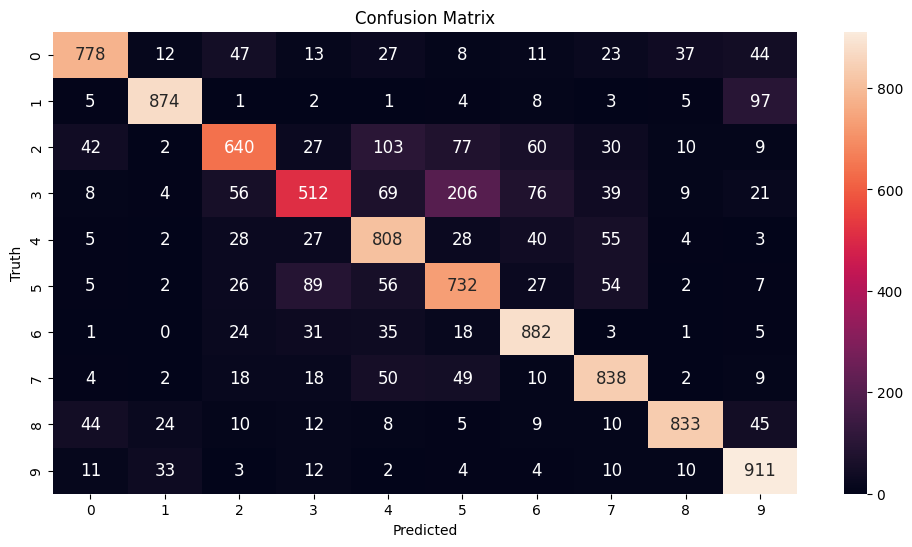

In [25]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[12, 6])
import seaborn as sn

sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()